In [ ]:
import math
!pip install yfinance
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [ ]:
stock_data = yf.download('aapl', start='2012-01-01', end='2023-07-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.482927,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.550011,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.689342,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.821990,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.801655,394024400


In [ ]:
close_prices = stock_data['Close']
values = close_prices.values

In [ ]:
training_data_len = math.ceil(len(values)* 0.8)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Epoch 1/2
2254/2254 [==============================] - 71s 27ms/step - loss: 8.3369e-04
Epoch 2/2
19/19 [==============================] - 1s 22ms/step


<ipython-input-6-acca597f2bac>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


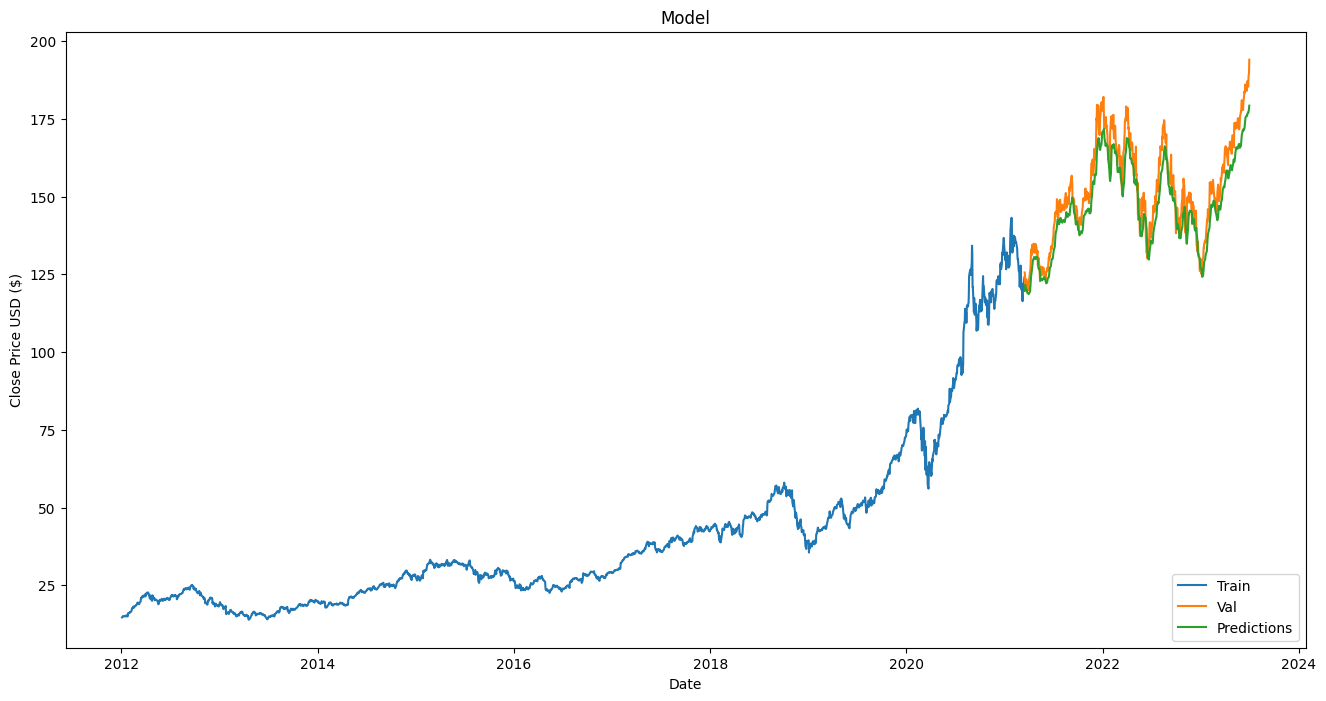

In [ ]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True,
input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
optimizer = tf.keras.optimizers.Adam(0.001)
optimizer.learning_rate.assign(0.001)
model.compile(optimizer, loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=2)

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

dat = stock_data.filter(['Close'])
train = dat[:training_data_len]
validation = dat[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

In [ ]:
data = stock_data
data = data[-math.floor(len(data)*20/100):]
y = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
from sklearn.metrics import accuracy_score

test_data = scaler.inverse_transform(test_data)
df = pd.DataFrame(predictions)
yy = np.where(df.shift(-1) > df, 1, 0)

In [ ]:
acc = accuracy_score(np.array(yy), np.array(y))
acc = acc*100
print(acc)